![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 21 - Metric Learning</center>
### <center> Local Fisher Discriminant Analysis (LFDA)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/21_MetricLearning/MainLFDA1.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Load heart data:

In [2]:
dData = pd.read_csv('heart_cleveland_upload.csv')
dData

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


### Normalized and classify the raw data:

In [3]:
mX   = dData.drop(columns=['condition']).values
vY   = dData['condition'].values
N, D = mX.shape

mX  = mX - np.mean(mX, axis=0)
mNX = mX / np.std(mX, axis=0)

In [4]:
from sklearn.svm import SVC

rawScore  = SVC(kernel='linear').fit(mX,  vY).score(mX,  vY)
normScore = SVC(kernel='linear').fit(mNX, vY).score(mNX, vY)
print(f'Linear classification accuracy (raw,        d = 13): {100*rawScore :2.2f}%')
print(f'Linear classification accuracy (normalized, d = 13): {100*normScore:2.2f}%')

Linear classification accuracy (raw,        d = 13): 84.51%
Linear classification accuracy (normalized, d = 13): 84.51%


### Apply PCA:

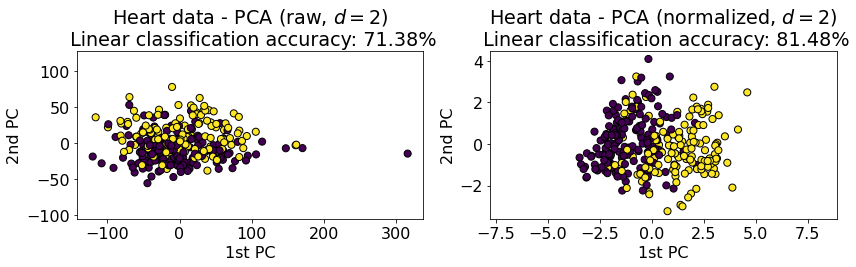

In [5]:
from sklearn.decomposition import PCA

mPca  = PCA(n_components=2).fit(mX).transform(mX)
mPcaN = PCA(n_components=2).fit(mNX).transform(mNX)

pcaScore     = SVC(kernel='linear').fit(mPca,  vY).score(mPca,  vY)
normPcaScore = SVC(kernel='linear').fit(mPcaN, vY).score(mPcaN, vY)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(mPca[:,0], mPca[:,1], s=50, c=vY, edgecolor='k')
plt.axis('equal')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.title('Heart data - PCA (raw, $d=2$)\n '\
          f'Linear classification accuracy: {100*pcaScore:2.2f}%')

plt.subplot(1,2,2)
plt.scatter(mPcaN[:,0], mPcaN[:,1], s=50, c=vY, edgecolor='k')
plt.axis('equal')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.title('Heart data - PCA (normalized, $d=2$)\n '\
          f'Linear classification accuracy: {100*normPcaScore:2.2f}%')

plt.tight_layout()
plt.show()

### FDA:

In [6]:
from scipy.linalg import eigh

def FDA(mX, vY):
    N, D   = mX.shape
    mX    -= mX.mean(axis=0)
    vC     = np.unique(vY)
    K      = len(vC)
    
    mSw = np.zeros((D, D))
    mSb = np.zeros((D, D))
    for kk in vC:
        vIdx = vY == kk
        Nk   = np.sum(vIdx)
        mXk  = mX[vIdx,:]
        vD   = np.mean(mXk, axis=0)[None,:]
     
        mSb += Nk * vD.T @ vD
        mSw += Nk * np.cov(mXk.T)

    vL, mW = eigh(mSb, mSw)
    vIdx   = np.argsort(-vL)[:K-1]
#     vL     = vL[vIdx]
    mW     = mW[:,vIdx]
    mZ     = mX @ mW
    
    return mZ

### Apply FDA:

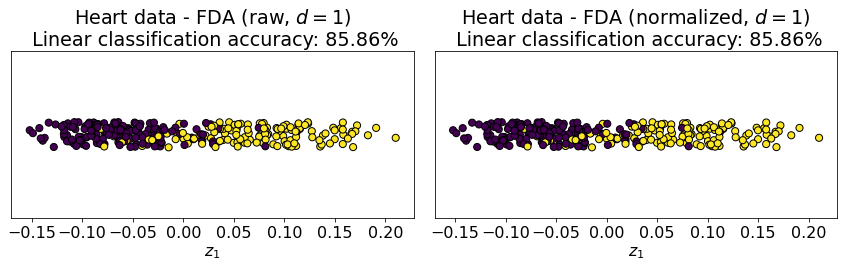

In [7]:
vZ  = FDA(mX, vY)
vNZ = FDA(mNX, vY)

fdaScore     = SVC(kernel='linear').fit(vZ,  vY).score(vZ,  vY)
normFdaScore = SVC(kernel='linear').fit(vNZ, vY).score(vNZ, vY)

vJitter = (np.random.rand(1,N)-1/2) / 40

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(vZ, vJitter, s=50, c=vY, edgecolor='k')
plt.axis('equal')
plt.xlabel('$z_1$')
plt.yticks([])
plt.title('Heart data - FDA (raw, $d=1$)\n '\
          f'Linear classification accuracy: {100*fdaScore:2.2f}%')

plt.subplot(1,2,2)
plt.scatter(vNZ, vJitter, s=50, c=vY, edgecolor='k')
plt.axis('equal')
plt.xlabel('$z_1$')
plt.yticks([])
plt.title('Heart data - FDA (normalized, $d=1$)\n '\
          f'Linear classification accuracy: {100*normFdaScore:2.2f}%')

plt.tight_layout()
plt.show()

### Apply LFDA:

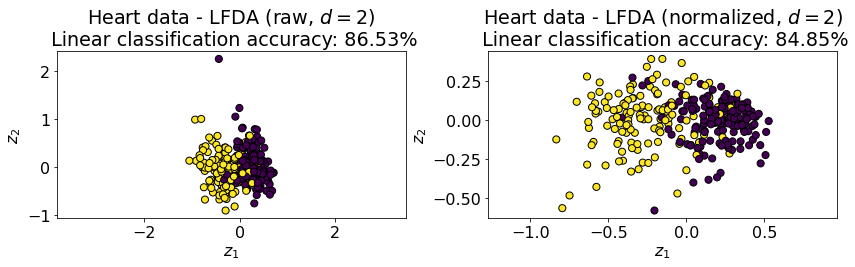

In [25]:
from metric_learn import LFDA

mZ  = LFDA(n_components=2).fit_transform(mX, vY)
mNZ = LFDA(n_components=2).fit_transform(mNX, vY)

lfdaScore     = SVC(kernel='linear').fit(mZ,  vY).score(mZ,  vY)
normLfdaScore = SVC(kernel='linear').fit(mNZ, vY).score(mNZ, vY)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(mZ[:,0], mZ[:,1], s=50, c=vY, edgecolor='k')
plt.axis('equal')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Heart data - LFDA (raw, $d=2$)\n '\
          f'Linear classification accuracy: {100*lfdaScore:2.2f}%')

plt.subplot(1,2,2)
plt.scatter(mNZ[:,0], mNZ[:,1], s=50, c=vY, edgecolor='k')
plt.axis('equal')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Heart data - LFDA (normalized, $d=2$)\n '\
          f'Linear classification accuracy: {100*normLfdaScore:2.2f}%')

plt.tight_layout()
plt.show()